# Developing an NLP Model using PyTorch

In this tutorial, we'll explore NLP and deep learning, leveraging the powerful capabilities of PyTorch and transformer models to solve a practical and impactful problem in the realm of education.

## Basic Introduction

NLP is a branch of artificial intelligence that focuses on the interaction between computers and humans through natural language. The ultimate objective of NLP is to read, decipher, understand, and make sense of human languages in a valuable way. With the advent of deep learning, NLP has seen remarkable advancements, particularly with the introduction of models like BERT and GPT, which are based on the transformer architecture.

PyTorch, a leading deep learning library, provides an intuitive interface for building and training complex models, including transformers. It is known for its flexibility, ease of use, and dynamic computation graph, making it a preferred choice for researchers and developers in the field of AI.

## Overview of the Problem

In this tutorial, we are going to tackle the challenge of developing an NLP model that can predict the grade level of a given piece of text. This involves analyzing the complexity, vocabulary, syntax, and overall structure of the writing and mapping it to a corresponding educational grade level. Such a task is crucial in educational settings, as it helps in understanding and assessing the writing skills of students across different age groups and educational stages.

### Applications of Grade Level Classification in Educational Tools
- **Personalized Learning**: Tailoring learning materials and exercises based on a student's writing proficiency.
- **Content Curation**: Assisting educators in selecting or creating text materials that are appropriate for the reading and comprehension levels of their students.
- **Automated Assessment**: Providing a tool for educators to quickly assess the writing level of student assignments, essays, and other written works.
- **Language Development Tracking**: Monitoring the progress of students’ language and writing skills over time.
- **Assistive Technology**: Offering support for students with learning disabilities by matching them with texts that suit their reading and comprehension levels.

## Approach to Solving the Problem

Our approach will be multi-faceted and will involve the following key steps:

1. **Data Acquisition and Preparation**: In another notebook, we developed a mock dataset of text samples annotated with grade levels using GPT. This dataset will then be preprocessed to be fed into our model.

2. **Constructing a Transformer Model**: We will explore the technique of using a pre-trained transformer model available in PyTorch.

3. **Fine-Tuning the Model**: We'll adapt and fine-tune the chosen transformer model for our specific classification task, modifying it to predict the grade level based on the input text.

4. **Training and Evaluation**: The model will be trained on our dataset, and we will evaluate its performance using various metrics to ensure its accuracy and reliability.

5. **Application and Deployment**: Finally, we'll discuss how to integrate this model into real-world educational applications and tools.

By the end of this tutorial, you will have gained hands-on experience in building and applying a sophisticated NLP model for a meaningful and practical purpose in the field of education.

### Import Necessary Libraries

In [1]:
import numpy as np
import h5py
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler
import re

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_gpu = torch.cuda.device_count()

print(f'Using Torch version: {torch.__version__}')
print(f'Using a {device} device with {n_gpu} GPU(s)')

Using Torch version: 2.0.1+cu117
Using a cpu device with 0 GPU(s)


### Creating a Custom Dataset Class for BERT-Based Grade Level Classification

In this section, we'll construct a custom dataset class to prepare our data for the grade level classification task using BERT. This class, `GradesTextDataset`, will be responsible for loading, preprocessing, and tokenizing the text data. We'll employ PyTorch's `Dataset` class for this purpose. The process involves several key steps:

#### Data Loading and Preprocessing
- **Conversion**: Text data, stored as byte strings, is decoded to standard strings.
- **Cleaning**: We employ regular expressions to remove the topic and purpose sections from the text.

#### Tokenization and Encoding
- **Tokenization**: The BERT tokenizer splits the text into tokens, which are words or subwords that the model understands.
- **Encoding**: Each token is mapped to an integer ID from BERT's vocabulary.
- **Special Tokens**: We add `[CLS]` at the start and `[SEP]` at the end of each sentence for BERT's requirements.

#### Attention Mask and Sequence Padding
- **Attention Mask**: This mask differentiates real data from padding, guiding the model on which tokens to focus.
- **Padding**: Shorter sequences are padded with `[PAD]` tokens to reach the maximum sequence length (`MAX_LEN`).
- **Truncation**: Longer sequences are truncated to `MAX_LEN`.


First let's determine how large to make `MAX_LEN`:

In [2]:
file_name = 'data/grade_level_writing.h5'
model_name = 'bert-base-cased'
grades = np.arange(3,13)

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the dataset
with h5py.File(file_name, 'r') as file:
    texts = file['text']

    # Tokenize the texts and record their lengths
    lengths = []
    for i in range(len(texts)):
        text = texts[i]
        # Decode text from bytes to string
        text = text.decode('utf-8')
        # Remove topic and purpose
        text = re.sub(r'#.*?\n\n', '', text)
        
        # Tokenize and encode the text
        tokens = tokenizer.encode(text, add_special_tokens=True)
        # Record the length
        lengths.append(len(tokens))

# Analyze the token lengths
max_len = int(np.max(lengths))

print(f"Suggested MAX_LEN: {max_len}")

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


Suggested MAX_LEN: 672


### Build the dataset

Split the data randomly into training and validation sets.

In [3]:
class GradesTextDataset(Dataset):
    def __init__(self, file_name, tokenizer, max_len, min_grade=3):
        self.file_name = file_name
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_grade = min_grade

    def __len__(self):
        with h5py.File(self.file_name, 'r') as file:
            return len(file['grade'])

    def __getitem__(self, idx):

        with h5py.File(self.file_name, 'r') as file:
            # Load sample
            text = file['text'][idx].decode('utf-8')
            grade = file['grade'][idx]

        # Remove topic and purpose
        text = re.sub(r'#.*?\n\n', '', text)

        # Convert grade to class
        cl = grade - self.min_grade

        # Tokenization and encoding the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'grade': torch.tensor(grade, dtype=torch.long),
            'class': torch.tensor(cl, dtype=torch.long),
        }

# Define max sequence length for BERT
MAX_LEN = 512

# Create dataset
full_dataset = GradesTextDataset(file_name=file_name,
                                 tokenizer=tokenizer,
                                 max_len=MAX_LEN,
                                min_grade=grades[0])

# Define the split sizes for training and validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Randomly split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f'The training dataset consists of {len(train_dataset)} samples and the validation set has {len(val_dataset)} samples.')

The training dataset consists of 658 samples and the validation set has 74 samples.


### Instantiate the DataLoader

Finally, the `DataLoader` is created to facilitate batch processing and shuffling of the data, making it ready for training with a PyTorch model.

This DataLoader will provide the necessary input for the BERT model, where each batch contains tokenized text, attention masks, and the corresponding grade levels as labels.

In [4]:
batch_size = 32
# Create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Fine-Tuning BERT for NLP Tasks

In this section of the tutorial, we will delve into BERT (Bidirectional Encoder Representations from Transformers), one of the most influential models in the world of Natural Language Processing (NLP). Developed by Google, BERT has revolutionized how machines understand human language. Its effectiveness in a wide range of NLP tasks makes it an ideal choice for our project on grade level classification of text.

### What is BERT?

BERT is a transformer-based machine learning technique for NLP pre-training. Unlike previous models that looked at text sequences either from left to right or combined left-to-right and right-to-left training, BERT reads the entire sequence of words at once. This bidirectional approach allows the model to understand the context of a word based on all of its surroundings (left and right of the word).

### Key Features of BERT

- **Deeply Bidirectional**: BERT's bidirectional nature allows it to understand the full context of a sentence, which is crucial for understanding the meaning of each word accurately.
- **Pre-trained on Large Text Corpora**: BERT is pre-trained on massive text corpora, like Wikipedia and the BooksCorpus, enabling it to have a broad understanding of language.
- **Fine-Tuning for Specific Tasks**: Despite its pre-trained knowledge, BERT can be fine-tuned with additional output layers to create state-of-the-art models for a wide range of tasks, such as sentiment analysis, question answering, and in our case, grade level classification.

### Benefits of Using BERT

1. **High Performance**: BERT has been shown to achieve state-of-the-art results on various NLP benchmarking tests.
2. **Contextual Understanding**: Its deep bidirectional nature allows for a better understanding of the context and nuances of language.
3. **Versatility**: Can be fine-tuned for a wide array of NLP tasks without substantial architecture modifications.

### Possible Drawbacks of BERT

1. **Computational Resources**: BERT's complexity requires significant computational power, especially for large datasets or when fine-tuning the larger BERT models.
2. **Fine-tuning Challenges**: Properly fine-tuning BERT for specific tasks can be challenging. It requires a balance between adapting it to the task at hand and not straying too far from its pre-trained knowledge base.
3. **Possible Overfitting on Smaller Datasets**: When dealing with smaller datasets, there's a risk of overfitting, as BERT has been trained on vast amounts of data.

BERT stands out as a powerful tool in the NLP toolkit. Its ability to understand the context and meaning of words in text makes it highly effective for tasks requiring a deep understanding of language. In the context of our educational tool for grade level classification, BERT's nuanced understanding of language structure and complexity can provide valuable insights into the writing level of students. However, we must be mindful of its resource requirements and the nuances of fine-tuning.

## Load Pretrained Model

In [5]:
# Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(grades))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Optimizer and Learning Rate Scheduler Setup

In this section, we configure the optimizer and the learning rate scheduler for training our BERT model. These components play a crucial role in the training process by controlling how the model's weights are updated and how the learning rate changes over time.

#### Optimizer: AdamW
- **Role**: The optimizer is responsible for updating the model weights to minimize the loss function. Here, we use `AdamW`, a variant of the Adam optimizer that is specifically designed for training deep learning models.
- **Learning Rate**: We set the learning rate to `5e-5`. This value is a commonly used starting point for fine-tuning BERT models. However, it might require adjustment based on the specific characteristics of your dataset.

#### Learning Rate Scheduler: Linear Scheduler with No Warmup
- **Role**: The learning rate scheduler adjusts the learning rate during training. It can help in faster convergence and better overall performance of the model.
- **Type**: We use a linear scheduler, which gradually decreases the learning rate from the initial value set in the optimizer to zero.
- **Warmup Steps**: We set `num_warmup_steps` to 0, meaning the learning rate starts decreasing linearly from the first training step. Adjusting the number of warmup steps can be beneficial in some cases, as it allows the model to initially learn rapidly and then fine-tune more slowly.

In [6]:
num_epochs = 10
lr = 5e-5

# Define optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# Learning rate scheduler
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

## Training

Perform the fine-tuning of the model weights and track the progress of the performance on the trainig and validation data.

In [7]:
# Set the model to training mode
model.train()

# Training loop
train_loss = []
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Initialize loss and accuracy
    total_loss, total_accuracy = 0, 0

    # Iterate over batches
    for batch in train_dataloader:
        # Move batch data to the same device as model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Update tracking variables
        total_loss += loss.item()
        _, predictions = torch.max(logits, dim=1)
        total_accuracy += torch.sum(predictions == labels)

    # Calculate average loss and accuracy over the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / (len(train_dataloader) * batch_size)
    print(f"Training loss: {avg_train_loss:0.2f}, accuracy: {avg_train_accuracy*100:0.1f}%")
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_accuracy)

    # Validation step
    model.eval()
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['class'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            _, predictions = torch.max(logits, dim=1)
            total_val_accuracy += torch.sum(predictions == labels)

    avg_val_accuracy = total_val_accuracy / (len(val_dataloader) * batch_size)
    print(f"Validation accuracy: {avg_val_accuracy*100:0.1f}%")
    val_acc.append(avg_val_accuracy)

    # Set the model back to training mode
    model.train()

Epoch 1/30
Training loss: 2.213531346548171, accuracy: 0.1607142835855484
Validation accuracy: 0.15625
Epoch 2/30
Training loss: 1.8872559638250441, accuracy: 0.2306547611951828
Validation accuracy: 0.2291666716337204
Epoch 3/30
Training loss: 1.6459598881857735, accuracy: 0.3333333432674408
Validation accuracy: 0.2083333283662796
Epoch 4/30
Training loss: 1.4452795528230213, accuracy: 0.4017857015132904
Validation accuracy: 0.2916666567325592
Epoch 5/30
Training loss: 1.2201123975572132, accuracy: 0.5163690447807312
Validation accuracy: 0.3020833432674408
Epoch 6/30
Training loss: 1.0157381948970614, accuracy: 0.6279761791229248
Validation accuracy: 0.2083333283662796
Epoch 7/30
Training loss: 0.9037468291464306, accuracy: 0.6473214030265808
Validation accuracy: 0.375
Epoch 8/30
Training loss: 0.7056820960271926, accuracy: 0.7559523582458496
Validation accuracy: 0.3333333432674408
Epoch 9/30
Training loss: 0.5025147483462379, accuracy: 0.8645833134651184
Validation accuracy: 0.3020833

### Display Training Progress

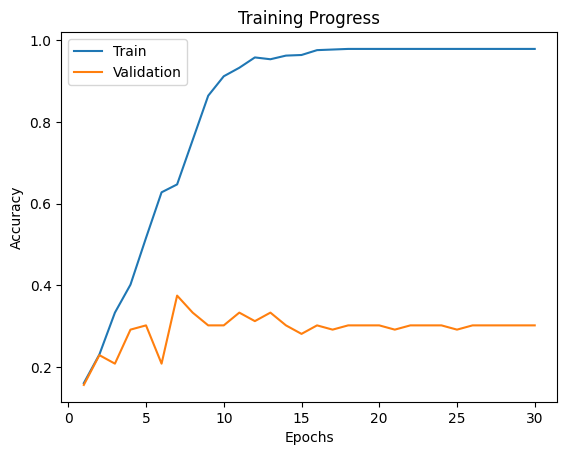

In [8]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs+1), train_acc, label='Train')
plt.plot(range(1, num_epochs+1), val_acc, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Progress')
plt.legend()
plt.show()

With such a small training set, it is expected that we would over-fit the model. However, the training illustrates that this model and training procedure can effectively learn the writing level of a given student.

### Confusion Matrix

- A confusion matrix will display the model’s predictions against the true labels, showing where the model is getting confused.
- It’s particularly useful for multi-class problems like grade level classification. You can see not just overall accuracy, but also which specific grades are being misclassified.

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def make_predictions(dataloader):
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            # Move batch data to the same device as model
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['class'].to(device)  # Assuming 'class' is the key for labels
    
            # Forward pass, get logits
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
    
            # Convert logits to predictions
            batch_predictions = torch.argmax(logits, dim=1)
            batch_labels = labels
    
            # Move predictions and labels to CPU, convert them to lists and extend the main lists
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())
    return true_labels, predictions

def conf_mat(dataloader, title):
    true_labels, predictions = make_predictions(dataloader)
    # Assuming 'true_labels' and 'predictions' are lists of true labels and model predictions
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

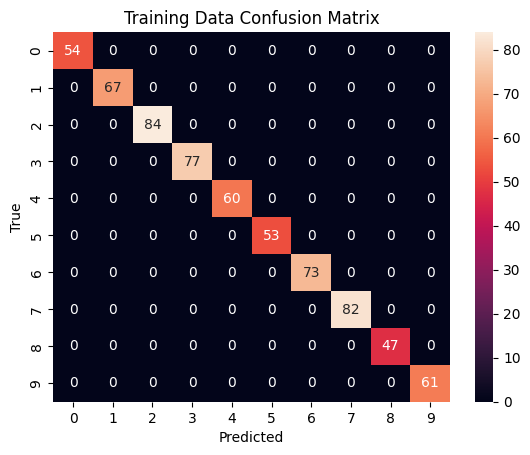

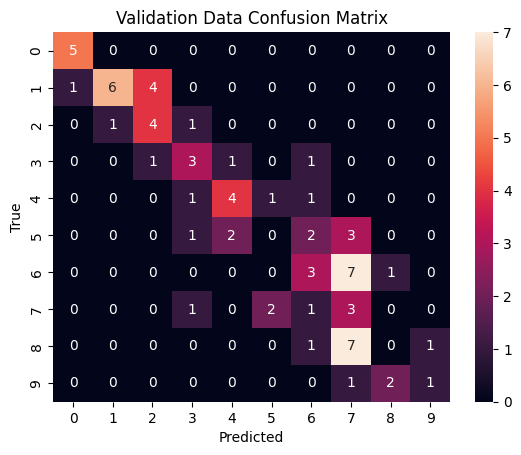

In [10]:
conf_mat(train_dataloader, title='Training Data')
conf_mat(val_dataloader, title='Validation Data')

It is apparent that the model routinely does not predict certain grades. This is likely due to the simple nature of the dataset since it was created using a GPT model with a very simple prompt.

However, even with this simple training set-up and basic dataset, it is definitely interesting!